In [1]:
import tensorflow as tf

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow_examples.models.pix2pix import pix2pix

# import tensorflow_datasets as tfds
# tfds.disable_progress_bar()

# from IPython.display import clear_output
import matplotlib.pyplot as plt

In [3]:
from __future__ import print_function
import os
import numpy as np
import skimage
from skimage import data, draw
from skimage import transform, util
import cv2
data_path = '../../Documents/ISIC2018-Segementation/'

image_rows = 420
image_cols = 580

In [4]:
def create_train_data():
    train_data_path = os.path.join(data_path, 'train/')
    images = sorted(os.listdir(train_data_path))
    total = len(images)
    imgs = np.ndarray((total, image_rows, image_cols, 1), dtype=np.uint8)

    i = 0
    print('-'*30)
    print('Creating train images...')
    print('-'*30)
    for image_name in images:
        # Read RGB image
        img = cv2.imread(os.path.join(train_data_path, image_name))
        # Convert to grayscale
        gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Rescale to image_rows x image_cols size
        resized_image = cv2.resize(gray_image, (image_cols, image_rows))
        resized_image = resized_image.reshape(resized_image.shape + (1,))
        img = np.array(resized_image)
        imgs[i] = img
        print('Done: {0}/{1} images'.format(i, total))
        i += 1
    print('Loading done.')

    np.save('imgs_train.npy', imgs)
    print('Saving to .npy files done.')

def create_train_masks_data():
    train_masks_data_path = os.path.join(data_path, 'train_masks/')
    images = sorted(os.listdir(train_masks_data_path))
    total = len(images)

    imgs = np.ndarray((total, image_rows, image_cols, 1), dtype=np.uint8)

    i = 0
    print('-'*30)
    print('Creating train masks images...')
    print('-'*30)
    for image_name in images:
#         print(image_name)
        # Read RGB image
        img = cv2.imread(os.path.join(train_masks_data_path, image_name))

        # Convert to grayscale
        gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Rescale to image_rows x image_cols size
        resized_image = cv2.resize(gray_image, (image_cols, image_rows))
        resized_image = resized_image.reshape(resized_image.shape + (1,))
        img = np.array(resized_image)

        img = np.array([img])

        imgs[i] = img

        print('Done: {0}/{1} images'.format(i, total))
        i += 1
    print('Loading done.')

    np.save('imgs_mask_train.npy', imgs)
    print('Saving to .npy files done.')

def load_train_data():
    imgs_train = np.load('imgs_train.npy')
    imgs_mask_train = np.load('imgs_mask_train.npy')
    return imgs_train, imgs_mask_train

# create_train_data()
# create_train_masks_data()

In [5]:
# from keras import backend as K
import tensorflow.keras.backend as K

img_rows = 64*3 #193
img_cols = 80*3 #240

#img_rows = 420
#img_cols = 580

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols, 1), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        resized_image = cv2.resize(imgs[i], (img_cols, img_rows), interpolation=cv2.INTER_CUBIC)
        imgs_p[i] = resized_image.reshape(resized_image.shape + (1,))
    return imgs_p

In [6]:
from sklearn.model_selection import train_test_split

train, mask = load_train_data()
train = preprocess(train)
mask = preprocess(mask)

train = train.astype('float32')
mean = np.mean(train)  # mean for data centering
std = np.std(train)  # std for data normalization

train -= mean
train /= std

mask = mask.astype('float32')
mask /= 255.  # scale masks to [0, 1]

X_train, X_test, y_train, y_test = train_test_split(train, mask, test_size=0.2, random_state=42)

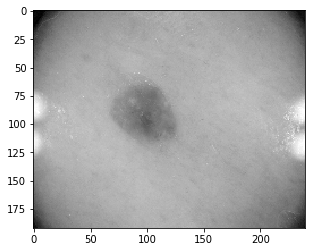

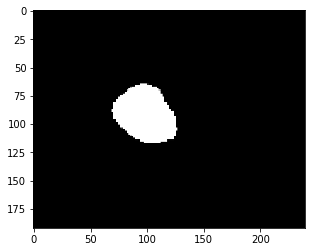

In [7]:
import random

img_index = random.randint(0, len(X_train))

plt.imshow(X_train[img_index].reshape(img_rows, img_cols), cmap='gray')
plt.show()

plt.imshow(y_train[img_index].reshape(img_rows, img_cols), cmap='gray')
plt.show()

In [8]:
import cv2
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Convolution2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def get_unet():
    concat_axis = 3
    
    inputs = Input(shape=[img_rows, img_cols, 1])
    conv1 = Convolution2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Convolution2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Convolution2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Convolution2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Convolution2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Convolution2D(512, (3, 3), activation='relu', padding='same')(conv5)

#     up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    up6 = Concatenate(axis=concat_axis)([UpSampling2D(size=(2, 2))(conv5), conv4])
    conv6 = Convolution2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Convolution2D(256, (3, 3), activation='relu', padding='same')(conv6)

#     up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    up7 = Concatenate(axis=concat_axis)([UpSampling2D(size=(2, 2))(conv6), conv3])
    conv7 = Convolution2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Convolution2D(128, (3, 3), activation='relu', padding='same')(conv7)

#     up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    up8 = Concatenate(axis=concat_axis)([UpSampling2D(size=(2, 2))(conv7), conv2])
    conv8 = Convolution2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Convolution2D(64, (3, 3), activation='relu', padding='same')(conv8)

#     up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    up9 = Concatenate(axis=concat_axis)([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Convolution2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Convolution2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Convolution2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    return model

In [23]:
model = get_unet()

model.compile(optimizer=Adam(lr=1e-4), 
              loss='binary_crossentropy', 
              metrics=['accuracy', 
                       tf.keras.metrics.MeanIoU(num_classes=2, name='MeanIoU')])

checkpoint = ModelCheckpoint(filepath='unet.hdf5', 
                             monitor='val_MeanIoU', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_MeanIoU', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)

callbacks_list = [checkpoint, reduce_lr]

history = model.fit(X_train,
                    y_train,
                    batch_size=8,
                    validation_data=(X_test, y_test),
                    validation_steps=8,
                    epochs=30, 
                    verbose=1,
                    callbacks=callbacks_list)

Train on 2075 samples, validate on 519 samples
Epoch 1/30
2072/2075 [============================>.] - ETA: 0s - loss: 0.3811 - accuracy: 0.8535 - MeanIoU: 0.3959
Epoch 00001: val_MeanIoU improved from -inf to 0.35847, saving model to unet.hdf5
2075/2075 [==============================] - 31s 15ms/sample - loss: 0.3810 - accuracy: 0.8535 - MeanIoU: 0.3958 - val_loss: 0.0402 - val_accuracy: 0.8806 - val_MeanIoU: 0.3585
Epoch 2/30
2072/2075 [============================>.] - ETA: 0s - loss: 0.2282 - accuracy: 0.9120 - MeanIoU: 0.3958
Epoch 00002: val_MeanIoU did not improve from 0.35847
2075/2075 [==============================] - 26s 13ms/sample - loss: 0.2281 - accuracy: 0.9120 - MeanIoU: 0.3958 - val_loss: 0.0287 - val_accuracy: 0.9065 - val_MeanIoU: 0.3585
Epoch 3/30
2072/2075 [============================>.] - ETA: 0s - loss: 0.1966 - accuracy: 0.9235 - MeanIoU: 0.3970
Epoch 00003: val_MeanIoU improved from 0.35847 to 0.35847, saving model to unet.hdf5

Epoch 00003: ReduceLROnPlatea

Epoch 23/30
2072/2075 [============================>.] - ETA: 0s - loss: 0.0755 - accuracy: 0.9655 - MeanIoU: 0.4401
Epoch 00023: val_MeanIoU did not improve from 0.39958
2075/2075 [==============================] - 26s 13ms/sample - loss: 0.0755 - accuracy: 0.9655 - MeanIoU: 0.4402 - val_loss: 0.0192 - val_accuracy: 0.9415 - val_MeanIoU: 0.3944
Epoch 24/30
2072/2075 [============================>.] - ETA: 0s - loss: 0.0733 - accuracy: 0.9663 - MeanIoU: 0.4414
Epoch 00024: val_MeanIoU did not improve from 0.39958
2075/2075 [==============================] - 26s 13ms/sample - loss: 0.0732 - accuracy: 0.9663 - MeanIoU: 0.4414 - val_loss: 0.0193 - val_accuracy: 0.9431 - val_MeanIoU: 0.3972
Epoch 25/30
2072/2075 [============================>.] - ETA: 0s - loss: 0.0705 - accuracy: 0.9675 - MeanIoU: 0.4463
Epoch 00025: val_MeanIoU improved from 0.39958 to 0.40182, saving model to unet.hdf5
2075/2075 [==============================] - 27s 13ms/sample - loss: 0.0705 - accuracy: 0.9675 - MeanI

In [10]:
# print('-'*30)
# print('Loading and preprocessing test data...')
# print('-'*30)
# imgs_test, imgs_id_test = load_test_data()
# imgs_test = load_test_data()
# imgs_test = preprocess(imgs_test)

# imgs_test = imgs_test.astype('float32')
# imgs_test -= mean
# imgs_test /= std
model = get_unet()
model.load_weights('unet.hdf5')
imgs_mask_test = model.predict(X_test)

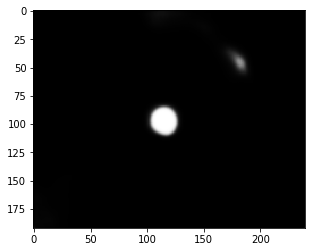

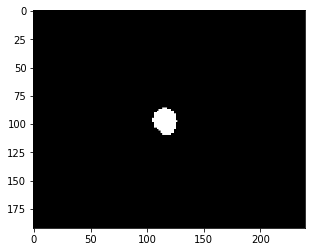

In [11]:
img_index = random.randint(0, len(X_test))

plt.imshow(imgs_mask_test[img_index].reshape(img_rows, img_cols), cmap='gray')
plt.show()

plt.imshow(y_test[img_index].reshape(img_rows, img_cols), cmap='gray')
plt.show()

# plt.imshow(imgs_mask_test)

In [12]:
test_data_path = os.path.join(data_path, 'test/')
images = sorted(os.listdir(test_data_path))
total = len(images)
raw_imgs = []
imgs = np.ndarray((total, image_rows, image_cols, 1), dtype=np.uint8)

i = 0
print('-'*30)
print('Creating test images...')
print('-'*30)
for image_name in images:
    # Read RGB image
    img = cv2.imread(os.path.join(test_data_path, image_name))
    raw_imgs.append(img)
    # Convert to grayscale
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Rescale to image_rows x image_cols size
    resized_image = cv2.resize(gray_image, (image_cols, image_rows))
    resized_image = resized_image.reshape(resized_image.shape + (1,))
    img = np.array(resized_image)
    imgs[i] = img
    print('Done: {0}/{1} images'.format(i, total))
    i += 1
print('Loading done.')

np.save('imgs_test.npy', imgs)
print('Saving to .npy files done.')

------------------------------
Creating test images...
------------------------------
Done: 0/100 images
Done: 1/100 images
Done: 2/100 images
Done: 3/100 images
Done: 4/100 images
Done: 5/100 images
Done: 6/100 images
Done: 7/100 images
Done: 8/100 images
Done: 9/100 images
Done: 10/100 images
Done: 11/100 images
Done: 12/100 images
Done: 13/100 images
Done: 14/100 images
Done: 15/100 images
Done: 16/100 images
Done: 17/100 images
Done: 18/100 images
Done: 19/100 images
Done: 20/100 images
Done: 21/100 images
Done: 22/100 images
Done: 23/100 images
Done: 24/100 images
Done: 25/100 images
Done: 26/100 images
Done: 27/100 images
Done: 28/100 images
Done: 29/100 images
Done: 30/100 images
Done: 31/100 images
Done: 32/100 images
Done: 33/100 images
Done: 34/100 images
Done: 35/100 images
Done: 36/100 images
Done: 37/100 images
Done: 38/100 images
Done: 39/100 images
Done: 40/100 images
Done: 41/100 images
Done: 42/100 images
Done: 43/100 images
Done: 44/100 images
Done: 45/100 images
Done

In [15]:
imgs_test = np.load('imgs_test.npy')

test = preprocess(imgs_test)
test = test.astype('float32')
mean = np.mean(test)  # mean for data centering
std = np.std(test)  # std for data normalization

test -= mean
test /= std

In [17]:
model = get_unet()
model.load_weights('unet.hdf5')
prediction = model.predict(test)

In [ ]:
img_index = random.randint(0, len(test))

plt.imshow(cv2.cvtColor(raw_imgs[img_index], cv2.COLOR_BGR2RGB))
plt.show()

# plt.imshow(test[img_index].reshape(img_rows, img_cols), cmap='gray')
# plt.show()

# plt.imshow(prediction[img_index].reshape(img_rows, img_cols), cmap='gray')
# plt.show()

img = cv2.resize(cv2.cvtColor(raw_imgs[img_index], cv2.COLOR_BGR2RGB), (240, 192))
mask = cv2.inRange(cv2.cvtColor(prediction[img_index], cv2.COLOR_GRAY2RGB),
                   (0.9, 0.9, 0.9),
                   (1, 1, 1))

# Create a blank 300x300 black image
red = np.zeros((192, 240, 3), np.uint8)
# Fill image with red color(set each pixel to red)
red[:] = (0, 50, 0)

plt.imshow(img + cv2.bitwise_and(red, red, mask=mask))

(192, 240, 3)
(192, 240, 3)


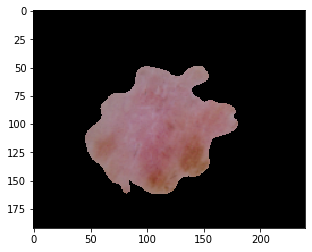

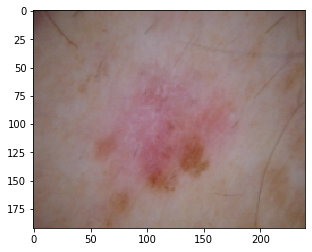

In [145]:
## mask = (prediction[img_index].reshape(img_rows, img_cols) > 9e-1)
c = cv2.cvtColor(raw_imgs[img_index], cv2.COLOR_BGR2RGB)
img= cv2.resize(img, (240, 192))

print(np.shape(img))
kk = cv2.cvtColor(prediction[img_index], cv2.COLOR_GRAY2RGB)
print(np.shape(kk))
mask = cv2.inRange(kk, (0.9, 0.9, 0.9), (1, 1, 1))

plt.imshow(cv2.bitwise_and(img, img, mask=mask))
plt.show()
plt.imshow(img)
plt.show()

In [135]:
kk

(array([[[0.06487566, 0.06487566, 0.06487566],
         [0.01580471, 0.01580471, 0.01580471],
         [0.00653976, 0.00653976, 0.00653976],
         ...,
         [0.00262588, 0.00262588, 0.00262588],
         [0.00557664, 0.00557664, 0.00557664],
         [0.01748583, 0.01748583, 0.01748583]],
 
        [[0.03547096, 0.03547096, 0.03547096],
         [0.01287672, 0.01287672, 0.01287672],
         [0.00930226, 0.00930226, 0.00930226],
         ...,
         [0.00344309, 0.00344309, 0.00344309],
         [0.0047777 , 0.0047777 , 0.0047777 ],
         [0.00975138, 0.00975138, 0.00975138]],
 
        [[0.01668233, 0.01668233, 0.01668233],
         [0.00595704, 0.00595704, 0.00595704],
         [0.00569218, 0.00569218, 0.00569218],
         ...,
         [0.00215444, 0.00215444, 0.00215444],
         [0.00252959, 0.00252959, 0.00252959],
         [0.00403872, 0.00403872, 0.00403872]],
 
        ...,
 
        [[0.0142855 , 0.0142855 , 0.0142855 ],
         [0.00523585, 0.00523585, 0.00523

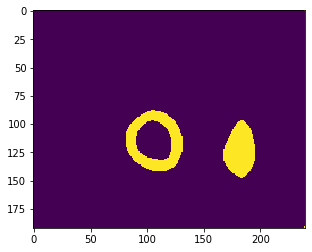

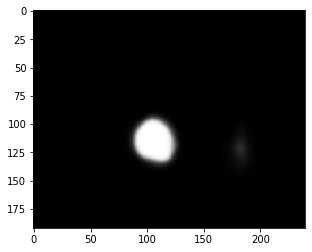

In [70]:
plt.imshow((prediction[0].reshape(img_rows, img_cols) > 0.01) & (prediction[0].reshape(img_rows, img_cols) < 0.8))
plt.show()

plt.imshow(prediction[0].reshape(img_rows, img_cols), cmap='gray')
plt.show()